# Metagenomic Classification - Amplicon Sequencing

This notebook trains a classification model on the amplicon sequencing dataset using a 5-mer stride 1 model following the Genomic-ULMFiT procedure. First the general bacterial genomic language model is fine tuned, then the fine tuned model is used to initialize the classification model.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [3]:
sys.path.append("../../..")
from utils import *

In [4]:
path = Path('F:/genome/bacterial genomes/')

# Amplicon LM

In [5]:
classification_df = pd.read_csv(path/'s16_amplicon_sequences.csv')

In [6]:
classification_df.head()

,Sequence,Species,set
0,TGGGGAATCTTAGACAATGGGCGCAAGCCTGATCTAGCCATGCCGC...,Alphaproteobacteria Rhodobacterales Rhodobacte...,train
1,TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGC...,Alphaproteobacteria Rhizobiales Hyphomicrobiac...,train
2,TGGGGAATATTGGACAATGGGCGAAAGCCTGATCCAGCAATGCCGC...,Alphaproteobacteria Sphingomonadales Sphingomo...,train
3,TGGGGAATCTTAGACAATGGGGGCAACCCTGATCTAGCGATGCCGC...,Alphaproteobacteria Rhodobacterales Rhodobacte...,train
4,TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGC...,Alphaproteobacteria Rhizobiales Xanthobacterac...,train


In [7]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [8]:
train_df.shape, valid_df.shape, test_df.shape

((23545, 3), (1772, 3), (1906, 3))

In [9]:
voc = np.load(path/'bact_vocab_3m1s.npy')
model_vocab = GenomicVocab(voc)

In [10]:
tok = Tokenizer(partial(GenomicTokenizer, ngram=3, stride=1), n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [11]:
data = GenomicTextLMDataBunch.from_df(path, train_df, valid_df, bs=880, tokenizer=tok, 
                              chunksize=10000, text_cols='Sequence', label_cols='Species', vocab=model_vocab)

In [14]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult = 0.5

In [15]:
learn = get_model_LM(data, drop_mult, config)

In [16]:
learn.load('b1_3m1s');

In [17]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(65, 400, padding_idx=0)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(65, 400, padding_idx=0)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=65, bias=True)
    (output_dp): RNNDropout()
  )
)

In [18]:
learn = learn.to_fp16(dynamic=True);

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


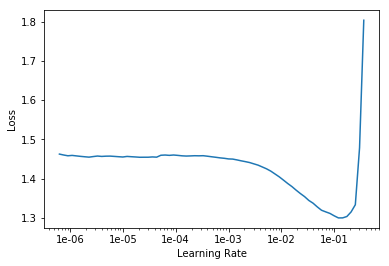

In [21]:
learn.recorder.plot()

# Training


In [22]:
learn.fit_one_cycle(20, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.132435,0.943709,0.590842,00:56
1,0.927408,0.832403,0.647467,00:57
2,0.821706,0.777911,0.676895,00:57
3,0.765386,0.766791,0.685181,00:57
4,0.730549,0.778753,0.683010,00:57
5,0.713950,0.826426,0.669351,00:57
6,0.705789,0.751137,0.697101,00:57
7,0.693482,0.754277,0.693994,00:57
8,0.681966,0.752326,0.696245,00:57
9,0.676447,0.741518,0.702273,00:57


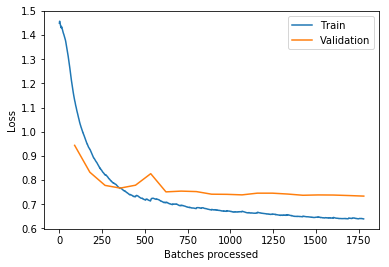

In [23]:
learn.recorder.plot_losses()

In [24]:
learn.save('s16_amp_LM_3m1s')
learn.save_encoder('s16_amp_LM_3m1s_enc')

# Classification

In [5]:
classification_df = pd.read_csv(path/'s16_amplicon_sequences.csv')

In [6]:
classification_df.head()

,Sequence,Species,set
0,TGGGGAATCTTAGACAATGGGCGCAAGCCTGATCTAGCCATGCCGC...,Alphaproteobacteria Rhodobacterales Rhodobacte...,train
1,TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGC...,Alphaproteobacteria Rhizobiales Hyphomicrobiac...,train
2,TGGGGAATATTGGACAATGGGCGAAAGCCTGATCCAGCAATGCCGC...,Alphaproteobacteria Sphingomonadales Sphingomo...,train
3,TGGGGAATCTTAGACAATGGGGGCAACCCTGATCTAGCGATGCCGC...,Alphaproteobacteria Rhodobacterales Rhodobacte...,train
4,TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGC...,Alphaproteobacteria Rhizobiales Xanthobacterac...,train


In [7]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [8]:
voc = np.load(path/'bact_vocab_3m1s.npy')
model_vocab = GenomicVocab(voc)

In [9]:
tok = Tokenizer(partial(GenomicTokenizer, ngram=3, stride=1), n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df,
                                             tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Species', bs=400)

In [12]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4, 
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.7

In [13]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [14]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(65, 400, padding_idx=0)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(65, 400, padding_idx=0)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.27999999999999997)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05,

In [15]:
learn.load_encoder('s16_amp_LM_3m1s_enc')
learn.freeze()

In [16]:
learn = learn.to_fp16(dynamic=True);

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


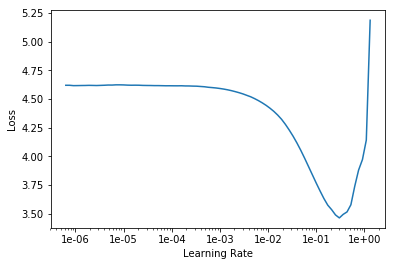

In [17]:
learn.lr_find()
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(6, 3e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.367007,0.943725,0.773702,00:30
1,1.065381,0.379740,0.868510,00:30
2,0.704169,0.315789,0.874153,00:30
3,0.544105,0.285843,0.886569,00:30
4,0.455181,0.246544,0.902935,00:30
5,0.411995,0.240444,0.902935,00:30


In [19]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.346439,0.222776,0.906885,00:36
1,0.292655,0.186423,0.915914,00:36
2,0.242740,0.184481,0.916479,00:36
3,0.214919,0.176391,0.916479,00:36


In [20]:
learn.freeze_to(-3)
learn.fit_one_cycle(4, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.197433,0.178850,0.919300,00:55
1,0.192951,0.174312,0.918172,00:55
2,0.182247,0.163319,0.919300,00:55
3,0.172195,0.158688,0.922686,00:55


In [21]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.167602,0.163746,0.924944,01:08
1,0.165602,0.159973,0.926072,01:08
2,0.161590,0.158608,0.924379,01:08
3,0.160711,0.157539,0.923815,01:08


In [22]:
learn.fit_one_cycle(8, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.162809,0.157219,0.923815,01:06
1,0.158835,0.163065,0.925508,01:07
2,0.158923,0.159004,0.925508,01:07
3,0.159477,0.157696,0.924944,01:08
4,0.156749,0.155827,0.922686,01:08
5,0.151381,0.153854,0.927765,01:07
6,0.151231,0.155434,0.924944,01:08
7,0.150727,0.154744,0.926637,01:08


In [23]:
learn.fit_one_cycle(8, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.149953,0.154406,0.924379,01:07
1,0.152838,0.158445,0.926072,01:08
2,0.148678,0.153976,0.922122,01:07
3,0.147688,0.154057,0.928894,01:07
4,0.145271,0.156387,0.921557,01:08
5,0.146059,0.153484,0.926637,01:08
6,0.146595,0.152978,0.924379,01:08
7,0.143992,0.153419,0.925508,01:08


In [24]:
learn.save('metagenomic_amp_genus_3m1s_finetune')

In [25]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4, 
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.6

In [26]:
learn = get_model_clas(data_clas, drop_mult, clas_config)
learn = learn.to_fp16(dynamic=True);

In [31]:
learn.load('metagenomic_amp_genus_3m1s_finetune');
learn.unfreeze()

In [33]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, test_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Species', bs=400)
learn.data = data_clas

In [34]:
preds = learn.get_preds()

In [35]:
p = torch.argmax(preds[0], dim=1)

In [36]:
precision_score(preds[1], p, average='macro')

0.9401872232953886

In [37]:
recall_score(preds[1], p, average='macro')

0.9332731996616351

In [38]:
accuracy_score(preds[1], p)

0.9239244491080797

In [39]:
f1_score(preds[1], p, average='macro')

0.9306932353004402

In [40]:
pred_df = pd.DataFrame(preds[1], columns=['gt_int'])

In [41]:
pred_df['gt_name'] = pred_df.gt_int.map(lambda x: data_clas.classes[x])

In [42]:
pred_df['predicted_int'] = p
pred_df['predicted_name'] = pred_df.predicted_int.map(lambda x: data_clas.classes[x])

In [43]:
pred_df.gt_name = pred_df.gt_name.map(lambda x: ' '.join(x.split('_', 1)) if len(x.split()) == 3 else x)

In [44]:
pred_df.predicted_name = pred_df.predicted_name.map(lambda x: ' '.join(x.split('_', 1)) if len(x.split()) == 3 else x)

In [45]:
taxa_list = ['Class', 'Order', 'Family', 'Genus']
for i, taxa in enumerate(taxa_list):
    print(taxa)
    print((pred_df.gt_name.map(lambda x: x.split()[i]) == pred_df.predicted_name.map(lambda x: x.split()[i])).mean())
    print('\n')

Class
1.0


Order
0.9994753410283316


Family
0.9863588667366212


Genus
0.9239244491080797


